In [14]:
import copy
%matplotlib inline

import sys
sys.path.append('..')

import xarray as xr
import numpy as np
from pathlib import Path
from itertools import product
import os
import matplotlib.pyplot as plt


In [15]:
data_dir = Path(os.getenv("OODIR"))

In [16]:
def area_average(grid, areas):
    lat_slice = grid.sel(latitude=slice(-90, 90))
    lat_lon_slice = lat_slice.sel(longitude=slice(-180, 180))
    weights = lat_lon_slice[0]
    weights.values = areas
    return lat_lon_slice.weighted(weights).mean(("longitude", "latitude"))

In [17]:
climatology = xr.open_dataset(data_dir / "SST_CCI_climatology" / "SST_1x1_daily.nc")
cos_lat_weights = np.cos(np.deg2rad(climatology.latitude))

# Use the SST values in the climatology as an ocean mask. Set area to 1 for gridcells with SSTs, 0 otherwise
climatology = climatology.sst[0].values
ocean = np.where(np.isnan(climatology), 0.0, 1.0)

# Areas are proportional to the cosine of latitude multiplied by the ocean area in the grid cell
areas = np.zeros((36, 72))
for xx, yy in product(range(72), range(36)):
    areas[yy, xx] = np.mean(ocean[yy*5:(yy+1)*5, xx*5:(xx+1)*5]) * np.cos(np.pi*(yy*5 - 87.5)/180.)

# normalise the areas to one at the equator
areas = areas/np.max(areas)

In [18]:
oo_anomalies = xr.open_dataset(data_dir / "IQUAM" / "oo_anomalies.nc")
oo = area_average(oo_anomalies.sst, areas)
oo_time = np.arange(len(oo))/12. + 1981. + 8./12.

In [19]:
oo2_anomalies = xr.open_dataset(data_dir / "IQUAM" / "oo_anomalies_twostep.nc")
oo2 = area_average(oo2_anomalies.sst, areas)

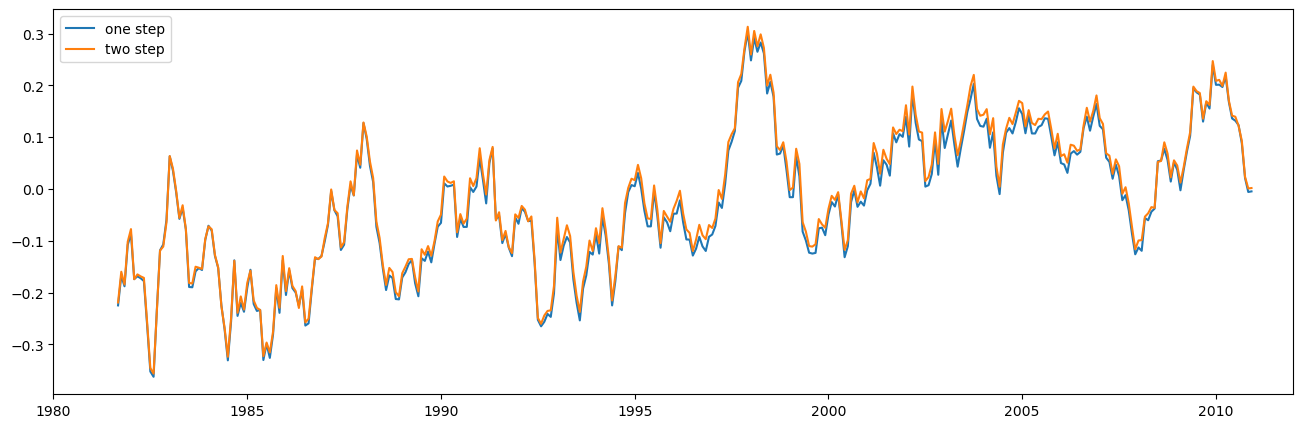

In [20]:
plt.figure()
plt.gcf().set_size_inches(16,5)
plt.plot(oo_time, oo, label="one step")
plt.plot(oo_time, oo2, label="two step")
plt.xlim(1980, 2012)
plt.legend()

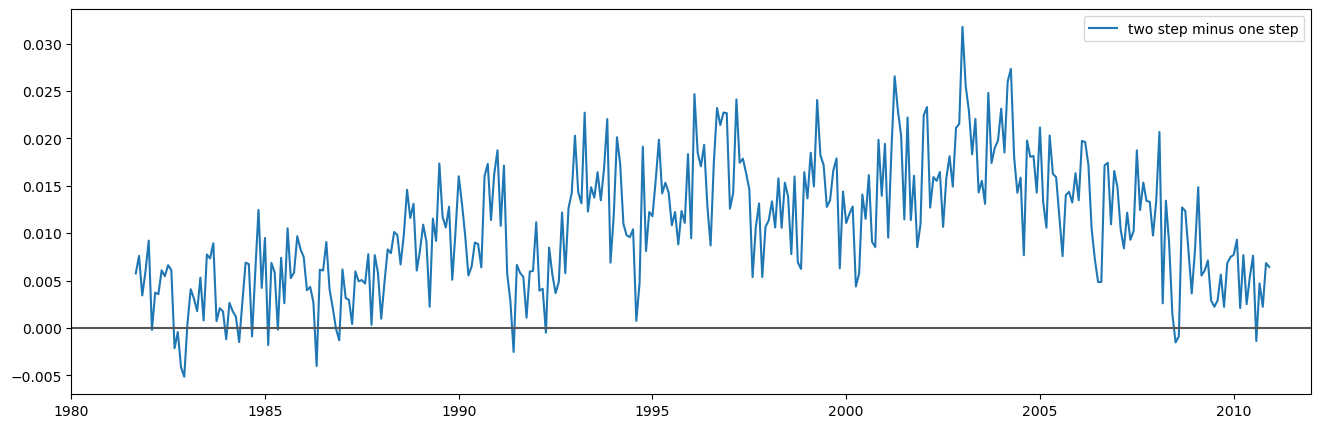

In [21]:
plt.figure()
plt.gcf().set_size_inches(16,5)
plt.plot(oo_time, oo2-oo, label="two step minus one step")
plt.plot([1980, 2012], [0,0], color="#555555")
plt.xlim(1980, 2012)
plt.legend()